# Produisez une étude de marché avec R ou Python

L'entreprise La Poule Qui Chante souhaite se développer à l'international. \
**Objectif : Proposer une première analyse des groupements de pays que l’on peut cibler pour exporter les poulets.**

In [1]:
# Librairies

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
# Paramètres d'affichage

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Étude de terrain : PESTEL

Indicateurs retenus, puis récupération des données sur le site de la FAO \
Politique: stabilité politique \
Économie: inflation, évolution de l'inflation, PIB, prix de la production, importation de France, crédit agricole \
Sociologiques : démographie, emploiement \
Technologiques : dépenses publiques en R&D \
Environnementaux : insécurité alimentaire, terres agricoles\
Légaux : 


### Préparation des données

#### 1. Données en pièce jointe

In [3]:
# Importation des fichiers csv donnés en p.j
    # data1 = Disponibilité alimentaire 2017
    # data2 = Population entre 2000 et 2018

data1 = pd.read_csv("DisponibiliteAlimentaire_2017.csv", sep=",", encoding="UTF-8")
data2 = pd.read_csv("Population_2000_2018.csv", sep=",", encoding="UTF-8")

In [4]:
# Nettoyage des données

# Disponibilité alimentaire
data1 = data1[(data1['Produit'] == 'Viande de Volailles')].reset_index() # filtre sur la catégorie volaille => poulet
data1 = data1.loc[:, ['Zone', 'Élément', 'Valeur']]
data1 = pd.crosstab(index=data1['Zone'], columns=data1['Élément'], values=data1['Valeur'], aggfunc='sum')
# vérification des valeurs manquantes, suppression des colonnes dont +90% des valeurs sont manquantes
data1 = data1[data1.columns[data1.isna().sum()/data1.shape[0] < 0.9]]
# après analyse du df, choix de remplir les valeurs manquantes restantes par 0
data1.fillna(0, inplace = True)
# garder les colonnes intéressantes
data1 = data1.loc[:,["Importations - Quantité", "Nourriture", "Production", "Exportations - Quantité"]] # exprimés en milliers de tonne
# Création colonne Total nourriture consommé
data3 = pd.read_csv("DisponibiliteAlimentaire_2017.csv", sep=",", encoding="UTF-8")
data3 = data3[(data3['Élément'] == 'Nourriture')].reset_index(drop=True)
data3 = data3[data3['Produit'].str.startswith('Viande')]
data3 = data3.groupby(['Zone']).agg({'Valeur': ['sum']}).reset_index()
data3.columns = [''.join(col) for col in data3]
data3 = data3.rename(columns={'Valeursum': 'Total Viande 2017'})
data1 = pd.merge(data1, data3, on='Zone', how='left')

In [5]:
# Population
data2 = data2[(data2['Année'] == 2017)].reset_index() # filtre sur l'année 2017 pour concorder avec le fichier précédent
data2 = data2.loc[:, ['Zone', 'Valeur']]
data2 = data2.rename(columns={'Valeur': 'Population 2017'})
data2['Population 2017'] = (data2['Population 2017']*1000).astype('int64')

In [6]:
# Fusion des deux dataframes

df = pd.merge(data1, data2, on='Zone', how='left')
del data1, data2

In [7]:
# Évolution démographique médianne
data2b = pd.read_csv("Population_2000_2018.csv", sep=",", encoding="UTF-8")
data2b = data2b.loc[:, ['Zone', 'Année', 'Valeur']]
data2b[['Taux_Évolution']] = data2b.sort_values(['Année']).groupby('Zone')[['Valeur']].pct_change()
# Remplacer les NaN par la moyenne
data2b['Taux_Évolution'] = data2b['Taux_Évolution'].fillna(data2b.groupby('Zone')['Taux_Évolution'].transform('mean'))
data2b = data2b.groupby(['Zone'], as_index=False).median()
data2b = data2b.loc[:, ['Zone', 'Taux_Évolution']]
data2b = data2b.rename(columns={'Taux_Évolution': 'Taux Évolution Population'})
df = pd.merge(data2b, df, on='Zone', how='left')
del data2b

In [8]:
# rapporter le nombre d'importation et nourriture consommée au nombre d'habitant
df['Importation (kg/pers)'] = round(df['Importations - Quantité']*1_000_000/df['Population 2017'], 2)
df['Nourriture Volaille (kg/pers)'] = round(df['Nourriture']*1_000_000/df['Population 2017'], 2)
df['Viande Total (kg/pers)'] = round(df['Total Viande 2017']*1_000_000/df['Population 2017'], 2)
df['Exportation (kg/pers)'] = round(df['Exportations - Quantité']*1_000_000/df['Population 2017'], 2)
df['Production (kg/pers)'] = round(df['Production']*1_000_000/df['Population 2017'], 2)
df = df.drop(columns = ['Importations - Quantité', 'Nourriture', 'Total Viande 2017', 'Production', 'Exportations - Quantité'])

# # colonne rapport volaille sur total
# df['Nourriture Volaille/Total (%)'] = round(df['Nourriture Volaille (kg/pers)']*100/df['Nourriture Total (kg/pers)'], 2)
# Suppression de cette variable suite à la matrice de covariance

# # colonne rapport volaille sur total viande
df['Nourriture Volaille/Total (%)'] = round(df['Nourriture Volaille (kg/pers)']*100/df['Viande Total (kg/pers)'], 2)

df.head()

,Zone,Taux Évolution Population,Population 2017,Importation (kg/pers),Nourriture Volaille (kg/pers),Viande Total (kg/pers),Exportation (kg/pers),Production (kg/pers),Nourriture Volaille/Total (%)
0,Afghanistan,0.031930,36296113.0,0.80,1.52,8.60,0.00,0.77,17.67
1,Afrique du Sud,0.014013,57009756.0,9.02,35.70,60.02,1.11,29.24,59.48
2,Albanie,-0.004211,2884169.0,13.18,16.30,47.15,0.00,4.51,34.57
3,Algérie,0.017370,41389189.0,0.05,6.38,18.07,0.00,6.64,35.31
4,Allemagne,0.000972,82658409.0,10.19,19.47,87.77,7.82,18.32,22.18


#### 2. Données complémentaires

In [9]:
# Politique : Stabilité politique
data6 = pd.read_csv("FAOSTAT_stabilité_politique.csv", sep=",", encoding="UTF-8")
data6 = data6[(data6['Année'] == 2017)].reset_index()
data6 = data6.loc[:, ['Zone', 'Valeur']]
data6 = data6.rename(columns={'Valeur': 'Indice de stabilité politique 2017'})
df = pd.merge(df, data6, on='Zone', how='left')
del data6

In [10]:
# Économie : Inflation
data4 = pd.read_csv("FAOSTAT_inflation.csv", sep=",", encoding="UTF-8")
data4 = data4[(data4['Année'] == 2017)].reset_index()
data4 = data4.loc[:, ['Zone', 'Valeur']]
data4 = data4.groupby('Zone').mean()
data4 = data4.rename(columns={'Valeur': 'Moy. Inflation 2017'})
df = pd.merge(df, data4, on='Zone', how='left')
del data4

In [11]:
# Économie : Évolution Inflation - Moyenne des taux d'inflations annuels
data7 = pd.read_csv("FAOSTAT_inflation.csv", sep=",", encoding="UTF-8")
data7 = data7.loc[:, ['Zone', 'Année', 'Mois', 'Valeur']]
data7 = data7.groupby(['Zone', 'Année'], as_index=False).mean()
data7[['Taux_Évolution']] = data7.sort_values(['Année']).groupby('Zone')[['Valeur']].pct_change()
# Remplacer les outliers par la médiane
g = data7.groupby('Zone').Taux_Évolution
data7['Taux_Évolution'] = (data7.Taux_Évolution.where(g.transform('quantile', q=0.95) > data7.Taux_Évolution, 
                            g.transform('median')))
# Moyenne des taux
data7 = data7.groupby(['Zone'], as_index=False).mean()
data7 = data7.loc[:, ['Zone', 'Taux_Évolution']]
data7 = data7.rename(columns={'Taux_Évolution': 'Taux Évolution Inflation'})
df = pd.merge(df, data7, on='Zone', how='left')
del data7

In [12]:
# Technologiques : Dépenses en R&D agricole
data5 = pd.read_csv("FAOSTAT_dépenses.csv", sep=",", encoding="UTF-8")
data5 = data5[(data5['Unité'] == "millions de dollars PPA (prix constants de 2011)")].reset_index()
data5 = data5.loc[:, ['Zone', 'Valeur']]
data5 = data5.groupby('Zone').mean()
data5 = data5.rename(columns={'Valeur': 'Moy. dépenses en R&D agricoles (millons dollars PPA)'})
del data5

# données seulement pour les pays à faibles et moyens revenus
# trop de valeurs manquantes, ne peut donc être retenu

In [13]:
# Économie : PIB
data8 = pd.read_csv("FAOSTAT_pib.csv", sep=",", encoding="UTF-8")
data8 = data8[(data8['Année'] == 2017)].reset_index()
data8 = data8.loc[:, ['Zone', 'Valeur']]
data8 = data8.rename(columns={'Valeur': 'PIB/hab. 2017 ($)'})
df = pd.merge(df, data8, on='Zone', how='left')
del data8

In [14]:
# Environnementaux : Prévalence de l'insécurité alimentaire modérée ou grave - population totale (%), moyenne sur 3 ans
data9 = pd.read_csv("FAOSTAT_insécurité_alimentaire.csv", sep=",", encoding="UTF-8")
# Remplir les valeurs manquantes / outliers par valeur médiane
g = data9.groupby('Zone').Valeur
data9['Valeur'] = (data9.Valeur.where(g.transform('quantile', q=0.95) > data9.Valeur, 
                            g.transform('median')))
# Si aucune donnée, remplir avec la moyenne totale
data9 = data9.mask(data9==0).fillna(data9.mean())
data9 = data9[(data9['Année'] == '2016-2018')].reset_index()
data9 = data9.loc[:, ['Zone', 'Valeur']]
data9 = data9.rename(columns={'Valeur': 'Insécurité Alimentaire 2016-2018 (pop. totale %)'})
data9 = data9.mask(data9==0).fillna(data9.mean())
df = pd.merge(df, data9, on='Zone', how='left')
del data9

C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12516/1539269877.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data9 = data9.mask(data9==0).fillna(data9.mean())
C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12516/1539269877.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data9 = data9.mask(data9==0).fillna(data9.mean())


In [15]:
# Économie : Prix production volaille
# data10 = pd.read_csv("FAOSTAT_prix_production_volaille.csv", sep=",", encoding="UTF-8")
# data10 = data10[(data10['Année'] == 2017)].reset_index()
# data10 = data10.loc[:, ['Zone', 'Valeur']]
# data10 = data10.rename(columns={'Valeur': 'Prix à la Production (USD/tonne) 2017'})
# df = pd.merge(df, data10, on='Zone', how='left')

# Variable non retenue car trop de valeur manquante in fine

In [16]:
# Environnementaux : Terres agricoles
data11 = pd.read_csv("FAOSTAT_terres_agricoles.csv", sep=",", encoding="UTF-8")
data11 = data11[(data11['Année'] == 2017)].reset_index()
data11 = data11.loc[:, ['Zone', 'Produit', 'Valeur']] # Valeur pour 1000 ha
data11 = np.round(pd.crosstab(data11.Zone, data11.Produit, data11.Valeur, aggfunc = 'mean'), 0)
data11.columns = [''.join(col) for col in data11]
data11['Terres agricoles/total (%)'] = data11['Agriculture'] / data11['Superficie des terres'] * 100
data11 = data11.rename(columns={'Agriculture': 'Terres agricoles'})
df = pd.merge(df, data11, on='Zone', how='left')
del data11

In [17]:
# Sociologiques : Emploiement
data12 = pd.read_csv("FAOSTAT_emploiement.csv", sep=",", encoding="UTF-8")
data12 = data12[(data12['Année'] == 2017)].reset_index()
data12 = data12[(data12['Indicateur'] == "Share of employees in agriculture (% of total employees)")].reset_index()
data12 = data12.loc[:, ['Zone', 'Valeur']] # exprimé en %
data12 = data12.rename(columns={'Valeur': "Part des employés dans l'agriculture (% du total des employés)"})
# après analyse du df, choix de remplir les valeurs manquantes par la moyenne
g = data12["Part des employés dans l'agriculture (% du total des employés)"].mean()
df = pd.merge(df, data12, on='Zone', how='left')
df["Part des employés dans l'agriculture (% du total des employés)"].fillna(g, inplace = True)
del data12

In [18]:
# Économie : Évolution de l'importation de poulet de France (têtes)
data13 = pd.read_csv("FAOSTAT_importation_de_France.csv", sep=",", encoding="UTF-8")
data13 = data13[(data13['Unité'] == '1000 têtes')].reset_index(drop=True)
# Taux d'Évolution
data13[['Taux_Évolution']] = data13.sort_values(['Année']).groupby('Pays déclarants')[['Valeur']].pct_change()
# Remplacer les outliers par la médiane
g = data13.groupby('Pays déclarants').Taux_Évolution
data13['Taux_Évolution'] = (data13.Taux_Évolution.where(g.transform('quantile', q=0.95) > data13.Taux_Évolution, 
                            g.transform('median')))
# Moyenne des taux
data13 = data13.groupby(['Pays déclarants'], as_index=False).mean()
data13 = data13.loc[:, ['Pays déclarants', 'Valeur', 'Taux_Évolution']]
data13 = data13.rename(columns={'Valeur': "Nb poulets importés de Fr. (1000 têtes)", 
                               'Pays déclarants': 'Zone',
                               'Taux_Évolution': "Taux d'évolution moy. d'import poulet de Fr."})
df = pd.merge(df, data13, on='Zone', how='left')
del data13

In [19]:
# Économie : Crédit agriculture
data14 = pd.read_csv("FAOSTAT_crédit_agriculture.csv", sep=",", encoding="UTF-8")
data14 = data14[(data14['Année'] == 2017)].reset_index(drop=True)
data14 = data14[(data14['Élément'] == "Part du Crédit Total US $")].reset_index(drop=True)
data14 = data14.loc[:, ['Zone', 'Valeur']] # unité exprimée en % - crédit l'Agriculture, Sylviculture et Pêche
data14 = data14.rename(columns={'Valeur': "Part crédit à l'agriculture 2017 (% sur total crédit)"})
df = pd.merge(df, data14, on='Zone', how='left')
del data14

In [20]:
# Environnementaux : Eaux continentales
data15 = pd.read_csv("FAOSTAT_eaux.csv", sep=",", encoding="UTF-8")
data15 = data15[(data15['Année'] == 2017)].reset_index(drop=True)
data15 = data15[(data15['Produit'] == 'Eaux continentales')].reset_index(drop=True)
data15 = data15.loc[:, ['Zone', 'Valeur']] # unité exprimé en 1000 ha
data15 = data15.rename(columns={'Valeur': "Eaux continentales (1000 ha)"})
df = pd.merge(df, data15, on='Zone', how='left')
del data15
# Eaux continentales : Zones correspondant à des cours d’eau naturels ou artificiels,
# servant à drainer les plans d’eau naturels ou artificiels, tels que les lacs, les réservoirs, 
# les cours d’eau, les ruisseaux, les étangs, les canaux intérieurs, les barrages et les autres étendues d’eau 
# (généralement douce) continentales. Les berges constituent des limites, que l’eau soit présente ou non.

In [21]:
# Économie : Indice commercial importation
data16 = pd.read_csv("FAOSTAT_indice_importation.csv", sep=",", encoding="UTF-8")
data16 = data16[(data16['Élément'] == "Indice de quantité d'importation (2014-2016 = 100)")].reset_index(drop=True)
data16 = data16[(data16['Année'] == 2017)].reset_index(drop=True)
data16 = data16.loc[:, ['Zone', 'Valeur']]
data16 = data16.rename(columns={'Valeur': "Indice qté importation volaille"})
df = pd.merge(df, data16, on='Zone', how='left')
del data16

In [22]:
# Religion
from wikitable import wikitable
url = "https://fr.wikipedia.org/wiki/Nombre_de_musulmans_par_pays"
w = wikitable(url, to_csv=True, overwrite=True, names = "Religion")

w = pd.read_csv("Religion1.csv", sep=",", encoding="UTF-8")
w = w.loc[:, ['Pays/Région', 'Population totale', 'Population musulmane']]
# Enlever les < et ≤
w['Population musulmane'] = w['Population musulmane'].str.replace('< ','')
w['Population musulmane'] = w['Population musulmane'].str.replace('≤ ','')
w['Population musulmane'] = w['Population musulmane'].str.replace(' ','')
# Lorsqu'il y a une fourchette, garder la fourchette basse
w[['Population musulmane','x']] = w['Population musulmane'].apply(lambda x: pd.Series(str(x).split("–")))
# Modifier le format
w['Population totale'] = w['Population totale'].str.replace("\\xa0",'').astype(int)
w['Population musulmane'] = w['Population musulmane'].str.replace("\\xa0",'').astype(int)
w['x'] = w['x'].str.replace("\\xa0",'').astype(float)
# # Calculer la part de musulmans sur total
w['x'] = w['Population musulmane']/w['Population totale']*100
w = w.rename(columns={'x': 'Population musulmane (% sur total)', 'Pays/Région': 'Zone'})
w = w.loc[:, ['Zone', 'Population musulmane (% sur total)']]

# Réconcilliation des noms de pays avant merge
# pays = pd.read_csv("Population_2000_2018.csv", sep=",", encoding="UTF-8")
# pays = pays.loc[:, ['Zone']]
# pays = pays.drop_duplicates()
# w = w.merge(pays, how='outer', left_on=['Pays/Région'], right_on=["Zone"])
# w[w['Zone'].isna() + w['Pays/Région'].isna()]

# Renommer les pays
w = w.replace({'Zone': {"Antilles néerlandaises":"Antilles néerlandaises (ex)", 
                               "Biélorussie":"Bélarus", 
                               "Bolivie":"Bolivie (État plurinational de)", 
                               "Brunei":"Brunéi Darussalam", 
                               "Cap-Vert":"Cabo Verde",
                               "Chine":"Chine, continentale",
                               "République du Congo":"Congo",
                               "Corée du Nord":"République de Corée",
                               "Corée du Sud":"République populaire démocratique de Corée",
                               "États-Unis":"États-Unis d'Amérique",
                               "Guyane":"Guyane française",
                               "Hong Kong":"Chine - RAS de Hong-Kong",
                               "Îles Caïmans":"Îles Caïmanes",
                               "Îles Vierges des États-Unis":"Îles Vierges américaines",
                               "Irak":"Iraq",
                               "Iran":"Iran (République islamique d')",
                               "Kosovo":"Serbie-et-Monténégro",
                               "Laos":"République démocratique populaire lao",
                               "Macao":"Chine - RAS de Macao",
                               "Malouines":"Îles Falkland (Malvinas)",
                               "États fédérés de Micronésie":"Micronésie (États fédérés de)",
                               "Moldavie":"République de Moldova",
                               "Nigeria":"Nigéria",
                               "Niue":"Nioué",
                               "La Réunion":"Réunion",
                               "Royaume-Uni":"Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
                               "Russie":"Fédération de Russie",
                               "Saint-Christophe-et-Niévès":"Saint-Kitts-et-Nevis",
                               "Saint-Vincent-et-les-Grenadines":"Saint-Vincent-et-les Grenadines",
                               "Salvador":"El Salvador",
                               "Swaziland":"Eswatini",
                               "Syrie":"République arabe syrienne",
                               "Taïwan":"Chine, Taiwan Province de",
                               "Tanzanie":"République-Unie de Tanzanie",
                               "République tchèque":"Tchéquie",
                               "Timor oriental":"Timor-Leste",
                               "Tokelau":"Tokélaou",
                               "Vatican":"Saint-Siège",
                               "Venezuela":"Venezuela (République bolivarienne du)",
                               "Viêt Nam":"Viet Nam",
                               "Wallis-et-Futuna":"Îles Wallis-et-Futuna",
                               "Birmanie":"Myanmar"
                              }})
df = pd.merge(df, w, on='Zone', how='left')

C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12516/1448978488.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  w['Population totale'] = w['Population totale'].str.replace("\\xa0",'').astype(int)
C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12516/1448978488.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  w['Population musulmane'] = w['Population musulmane'].str.replace("\\xa0",'').astype(int)
C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12516/1448978488.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  w['x'] = w['x'].str.replace("\\xa0",'').astype(float)


In [23]:
# Économie : Indice des prix à la consommation alimentaire (janvier 2021)
data17 = pd.read_csv("FAOSTAT_indice_conso.csv", sep=",", encoding="UTF-8")
data17 = data17.loc[:, ['Zone', 'Valeur']] # Prix à la Consommation, Indices d'alimentation (2015 = 100)
data17 = data17.rename(columns={'Valeur': "Indice prix conso"})
df = pd.merge(df, data17, on='Zone', how='left')
del data17

In [24]:
# Sociologique : démographie femme/homme et urbaine/rural
data18 = pd.read_csv("FAOSTAT_population.csv", sep=",", encoding="UTF-8")
data18 = data18[(data18['Année'] == 2017)].reset_index(drop=True)
data18 = data18.loc[:, ['Zone', 'Élément', 'Valeur']] # Unité 1000 personnes
data18 = pd.crosstab(index=data18['Zone'], columns=data18['Élément'], values=data18['Valeur'], aggfunc='sum')
# data18['%Femmes'] = data18['Femmes'] / data18['Population totale'] * 100
# data18['%Hommes'] = data18['Hommes'] / data18['Population totale'] * 100
data18['%Population rurale'] = data18['Population rurale'] / data18['Population totale'] * 100
data18['%Population urbaine'] = data18['Population urbaine'] / data18['Population totale'] * 100
data18.columns = [''.join(col) for col in data18]
data18 = data18.loc[:, ['%Population rurale', '%Population urbaine']]
df = pd.merge(df, data18, on='Zone', how='left')
del data18

In [25]:
# Politique : Évolution de la stabilité politique
data19 = pd.read_csv("FAOSTAT_stabilité_politique.csv", sep=",", encoding="UTF-8")
data19 = data19[(data19['Année'] > 2009)].reset_index(drop=True)
data19 = data19.loc[:, ['Zone', 'Année', 'Valeur']]
# Taux d'Évolution
data19[['Taux_Évolution']] = data19.sort_values(['Année']).groupby('Zone')[['Valeur']].pct_change()
# Remplacer les outliers par la médiane
g = data19.groupby('Zone').Taux_Évolution
data19['Taux_Évolution'] = (data19.Taux_Évolution.where(g.transform('quantile', q=0.95) > data19.Taux_Évolution, 
                            g.transform('median')))
# Moyenne des taux
data19 = data19.groupby(['Zone'], as_index=False).mean()
data19 = data19.loc[:, ['Zone', 'Taux_Évolution']]
data19 = data19.rename(columns={'Taux_Évolution': 'Taux Évolution Indice Stabilité'}) # sur les 10 dernières années
df = pd.merge(df, data19, on='Zone', how='left')
del data19

In [26]:
# Divers
data20 = pd.read_csv("FAOSTAT_divers.csv", sep=",", encoding="UTF-8")
data20 = data20.loc[:, ['Zone', 'Produit', 'Valeur']]
data20 = pd.crosstab(index=data20['Zone'], columns=data20['Produit'], values=data20['Valeur'], aggfunc='sum')
data20.columns = [''.join(col) for col in data20]
df = pd.merge(df, data20, on='Zone', how='left')
del data20

In [27]:
# Économie : En moyenne sur les 10 dernières années l'importation de poulet de France / population moy.
data21 = pd.read_csv("FAOSTAT_importation_de_France.csv", sep=",", encoding="UTF-8")
data21 = data21[(data21['Année'] > 2007)].reset_index(drop=True)
data21 = data21[(data21['Unité'] != 'tonnes')].reset_index(drop=True)
data21 = data21.loc[:, ['Pays déclarants', 'Année', 'Unité', 'Valeur']]
data21 = data21.rename(columns={'Pays déclarants': 'Zone'}) 

data2 = pd.read_csv("Population_2000_2018.csv", sep=",", encoding="UTF-8")
data2 = data2[(data2['Année'] > 2007)].reset_index(drop=True)
data2 = data2.loc[:, ['Zone', 'Année', 'Valeur']]

data21 = pd.merge(data21, data2, on=['Zone', 'Année'], how='left')

data21['Valeur'] = data21['Valeur_x']/data21['Valeur_y']*100
data21 = data21.groupby(['Zone', 'Année', 'Unité'], as_index=False).mean()
data21 = pd.crosstab(index=data21['Zone'], columns=data21['Unité'], values=data21['Valeur'], aggfunc='mean')
data21.columns = [''.join(col) for col in data21]
data21 = data21.rename(columns={'1000 US$': 'Moy. import de FR (% 1000 US$/pers)', 
                               '1000 têtes': 'Moy. import de FR (% 1000 têtes/pers)'
                               }) # sur les 10 dernières années
del data21
# Test sur une itération pour améliorer clustering, variable non retenue

In [28]:
df

,Zone,Taux Évolution Population,Population 2017,Importation (kg/pers),Nourriture Volaille (kg/pers),Viande Total (kg/pers),Exportation (kg/pers),Production (kg/pers),Nourriture Volaille/Total (%),Indice de stabilité politique 2017,Moy. Inflation 2017,Taux Évolution Inflation,PIB/hab. 2017 ($),Insécurité Alimentaire 2016-2018 (pop. totale %),Terres agricoles,Superficie des terres,Terres agricoles/total (%),Part des employés dans l'agriculture (% du total des employés),Nb poulets importés de Fr. (1000 têtes),Taux d'évolution moy. d'import poulet de Fr.,Part crédit à l'agriculture 2017 (% sur total crédit),Eaux continentales (1000 ha),Indice qté importation volaille,Population musulmane (% sur total),Indice prix conso,%Population rurale,%Population urbaine,Taux Évolution Indice Stabilité,Densité du réseau ferroviaire (pour 100 km carrés de surface totale du pays),Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Pourcentage de la population ayant accès à des services d'eau potable gérés en toute sécurité,Prévalence de l'excès pondéral chez l’enfant de moins de 5 ans (estimation modélisée) (%),Stabilité politique et absence de violence/terrorisme (indice),Valeur des importations alimentaires par rapport aux exportations totales de marchandises (%) (moyenne sur 3 ans)
0,Afghanistan,0.031930,3.629611e+07,0.80,1.52,8.60,0.00,0.77,17.67,-2.80,6.957529,-0.651706,2058.4,54.300000,37910.0,65223.0,58.123668,6.670941,NaN,NaN,NaN,63.0000,72.0,99.703783,1.282600e+02,73.172047,24.717446,-0.006767,NaN,10.7,25.1,4.4,-2.80,369.0
1,Afrique du Sud,0.014013,5.700976e+07,9.02,35.70,60.02,1.11,29.24,59.48,-0.28,6.905835,0.230740,12701.3,43.900000,96341.0,121309.0,79.417850,5.749251,22.900000,-0.331893,NaN,600.0000,128.0,1.818950,1.374903e+02,33.974890,65.511864,-0.264762,1.7,36.0,NaN,12.9,-0.28,6.0
2,Albanie,-0.004211,2.884169e+06,13.18,16.30,47.15,0.00,4.51,34.57,0.38,4.135979,-0.299215,12771.0,38.600000,1171.0,2740.0,42.737226,2.565676,11.666667,-0.328704,1.471404,33.0000,85.0,58.799988,1.171385e+02,41.265092,60.330445,-0.260716,NaN,62.7,70.6,16.4,0.38,21.0
3,Algérie,0.017370,4.138919e+07,0.05,6.38,18.07,0.00,6.64,35.31,-0.92,5.040496,-0.142547,11737.4,19.700000,41335.0,238174.0,17.354959,5.853789,2415.736842,-0.056354,NaN,NaN,NaN,99.000000,1.144974e+02,27.899875,71.928469,-0.042921,0.2,25.6,74.6,13.1,-0.92,23.0
4,Allemagne,0.000972,8.265841e+07,10.19,19.47,87.77,7.82,18.32,22.18,0.59,2.762497,-0.008286,52952.9,3.600000,18097.0,34937.0,51.798952,0.761077,1550.100000,3.095333,3.574682,788.0000,112.0,5.421687,1.113000e+02,22.589474,76.752172,-0.050319,9.4,63.0,99.0,3.9,0.59,5.0
5,Andorre,0.007167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.42,2.877625,-0.107029,NaN,28.332543,19.0,47.0,40.425532,6.670941,NaN,NaN,NaN,NaN,NaN,2.599524,1.102457e+02,11.844002,88.109245,0.012262,NaN,NaN,90.6,NaN,1.42,NaN
6,Angola,0.035668,2.981677e+07,9.29,10.56,23.51,0.00,1.41,44.92,-0.33,28.911962,-0.108584,7310.9,70.100000,56397.0,124670.0,45.237026,6.670941,NaN,NaN,6.089705,NaN,100.0,0.296483,3.353284e+02,35.123038,64.767718,0.002506,NaN,15.7,NaN,3.1,-0.33,7.0
7,Anguilla,0.014928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.203278,-0.491396,NaN,NaN,NaN,9.0,NaN,6.670941,NaN,NaN,0.088098,NaN,NaN,5.739869,1.043229e+02,0.000000,102.228470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Antigua-et-Barbuda,0.013221,9.542600e+04,73.36,52.40,73.36,0.00,0.00,71.43,0.75,1.874554,-1.035424,19840.3,28.332543,9.0,44.0,20.454545,6.670941,NaN,NaN,0.021568,NaN,120.0,1.042949,1.087818e+02,80.483306,26.418377,0.001168,NaN,50.0,NaN,NaN,0.75,98.0
9,Antilles néerlandaises (ex),0.013536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.670941,NaN,NaN,NaN,NaN,NaN,0.328128,NaN,8.621078,73.525906,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
np.shape(df)

(238, 34)

In [30]:
# Supprimer les lignes qui contiennent 50% ou plus de 50% de valeurs NaN
perc = 50.0
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna(axis=0, thresh=min_count)

In [31]:
# Index
df = df.set_index('Zone')
# Remplacer les NaN restants par 0 (selon les variables, NaN a déjà pu être imputé d'une valeur dans le DF avant merge)
df = df.fillna(0)
# Remplacer les inf par 0
from numpy import inf
df[df == inf] = 0
df[df == -inf] = 0

df_base = df.copy()

np.shape(df)

(191, 33)

Modification du DF après analyse:
- Suppression de la variable 'Superficie des terres' car corrélation à 92% avec la variable 'Terres agricoles'
- Suppression des outliers Koweït et Venezuela, chacun est un cluster isolé dû à une trop importante inflation (Moy. Inflation 2017 ou Taux Évolution Inflation)
- Suppression des variables qui contribuent peu aux premières composantes principales et des variables "statiques"
- Suppresion du Soudn du sud cause indice de stabilité très faible - outlier cluster

In [32]:
df = df_base.copy()
df = df.drop(columns = ['Superficie des terres'])
df = df.drop(["Koweït", "Venezuela (République bolivarienne du)"])
df = df.drop(columns = ['Eaux continentales (1000 ha)', 
                        "Part des employés dans l'agriculture (% du total des employés)",
                        "Viande Total (kg/pers)",
                        "Population 2017",
                        "Terres agricoles",
                        "Part crédit à l'agriculture 2017 (% sur total crédit)",
                        "Moy. Inflation 2017",
                        "Nb poulets importés de Fr. (1000 têtes)",
                        "%Population urbaine",
                        "Taux Évolution Indice Stabilité",
                        "Indice qté importation volaille",
                        "Taux d'évolution moy. d'import poulet de Fr.",
                        "Stabilité politique et absence de violence/terrorisme (indice)",
                        "Indice prix conso"
                        ])
df = df.drop(["Soudan du Sud"])

### Préparation de l'ACP

Les 2 objectifs de l’ACP :

- Étudier la variabilité des individus (leurs ressemblances et différences) ;

- Étudier les liaisons entre les variables (et au besoin, regrouper les variables liées en nouvelles variables synthétiques pour réduire le nombre de colonnes de nos données).

In [33]:
# Importation des librairies
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import decomposition
from scipy.spatial.distance import cdist

### Centrer & Réduire les données

In [34]:
# Matrice des données brutes
X = df.values
# Créer l'objet
scaler = StandardScaler()
# # Calcul de la moyenne et écart-type
scaler.fit(X)
# Transformer les valeurs
X_scaled = scaler.transform(X)

### Matrice de covariance

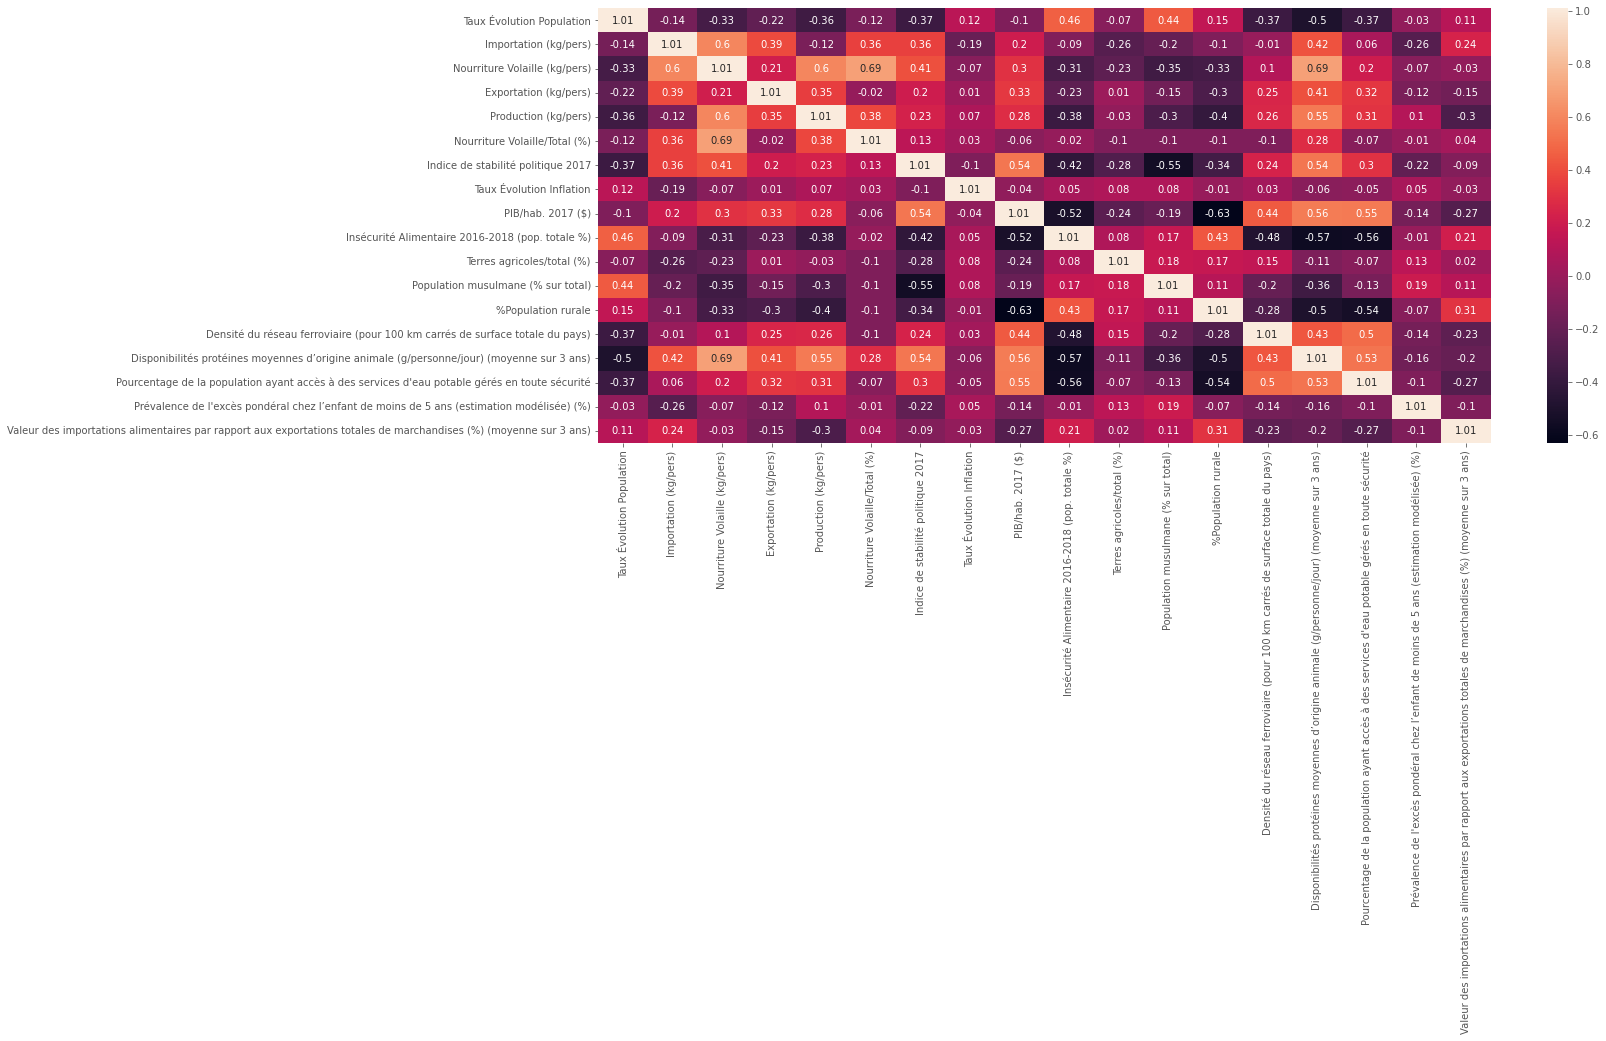

In [35]:
# Afficher la matrice de covariance pour visualiser la corrélation entre les variables
# Éviter les redondances d'information entre les variables
cov = pd.DataFrame(X_scaled,columns=df.columns.values)
covMatrix = pd.DataFrame.cov(cov).round(2)
fig = plt.subplots(figsize=(20,8))
sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

### Analyse en Composante Principale
Méthode factorielle de réduction de dimension pour l’exploration statistique de données quantitatives complexes. L’ACP est une analyse factorielle, en ce sens qu’elle produit des facteurs (ou axes principaux) qui sont des combinaisons linéaires des variables initiales, hiérarchisées et indépendantes les unes des autres. 

### Calcul des composantes principales

In [36]:
# Nombre de composantes souhaitées
n_comp = X.shape[1]

# Indiquer les composantes à afficher sur le plan factoriel
comp1 = 0
comp2 = 1

pca = PCA(n_components = n_comp, random_state = 25 )
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

pca_out = PCA().fit(X_scaled)
pca_out.explained_variance_ratio_

array([0.30075482, 0.12591258, 0.09056251, 0.07570758, 0.06395582,
       0.05731642, 0.0491958 , 0.04410233, 0.03482894, 0.03210898,
       0.02709367, 0.02581433, 0.01840407, 0.01703197, 0.01613741,
       0.01130255, 0.00848199, 0.00128822])

### Éboulis des valeurs propres

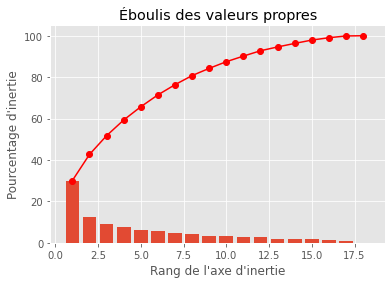

L'inertie des 2 premières composantes principales correspond à 42.67% de l'inertie totale
L'inertie des 4 premières composantes principales correspond à 59.29% de l'inertie totale
L'inertie des 6 premières composantes principales correspond à 71.42% de l'inertie totale
L'inertie des 8 premières composantes principales correspond à 80.75% de l'inertie totale


In [37]:
# Fonction Éboulis des valeurs propres

def display_scree_plot(pca):    
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Éboulis des valeurs propres")
    plt.show(block=False)
    
    print("L'inertie des {:.0f} premières composantes principales correspond à {:.2f}% de l'inertie totale".format(
        2, np.cumsum(pca.explained_variance_ratio_ * 100)[1]))
    print("L'inertie des {:.0f} premières composantes principales correspond à {:.2f}% de l'inertie totale".format(
        4, np.cumsum(pca.explained_variance_ratio_ * 100)[3]))
    print("L'inertie des {:.0f} premières composantes principales correspond à {:.2f}% de l'inertie totale".format(
        6, np.cumsum(pca.explained_variance_ratio_ * 100)[5]))
    print("L'inertie des {:.0f} premières composantes principales correspond à {:.2f}% de l'inertie totale".format(
        8, np.cumsum(pca.explained_variance_ratio_ * 100)[7]))
    
display_scree_plot(pca)

### Contribution des variables aux composantes

In [38]:
# Contribution des variables aux composantes
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['Variables'] = df.columns.values
loadings_df = loadings_df.set_index('Variables')

### Heatmap des contributions

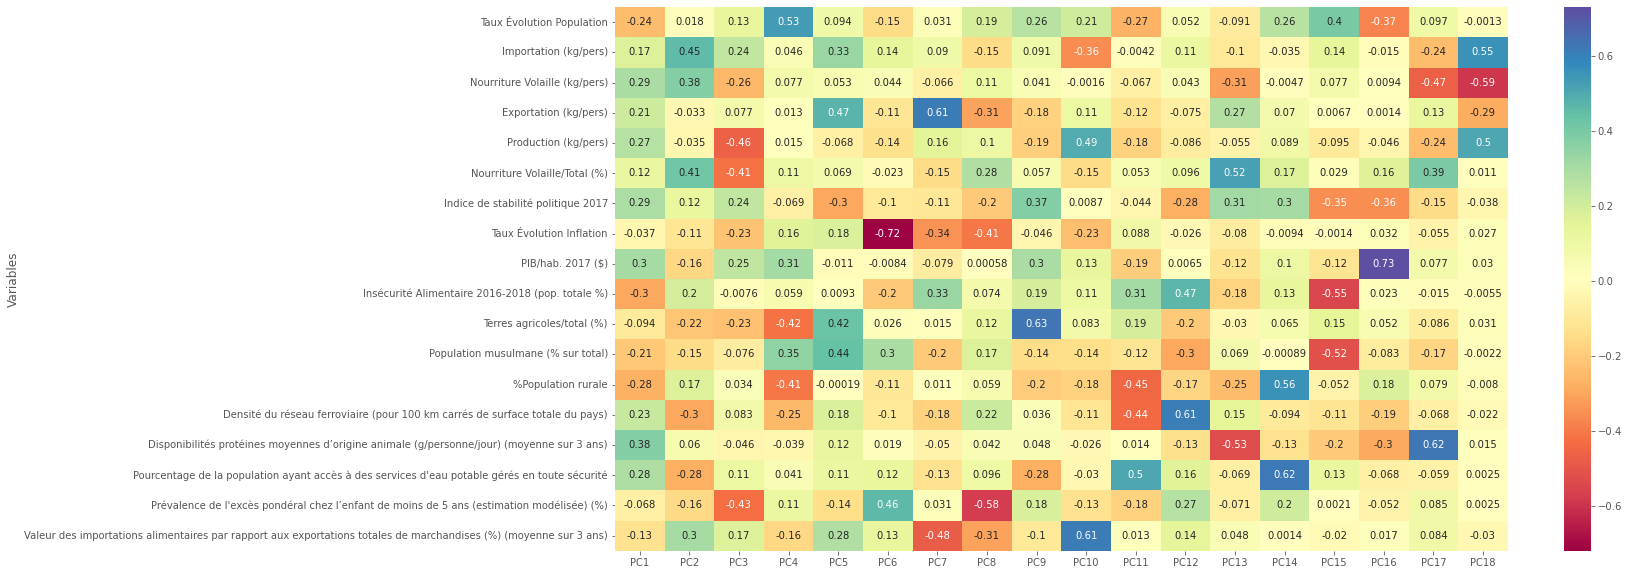

In [39]:
# Heatmap des contributions
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [40]:
# # https://www.reneshbedre.com/blog/principal-component-analysis.html
# # Génère les graphiques dans un fichier
# from bioinfokit.visuz import cluster

# # get PC scores
# pca_scores = PCA().fit_transform(X_scaled)

# # get 2D biplot
# cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
#                var1=round(pca_out.explained_variance_ratio_[comp1]*100, 2),
#                var2=round(pca_out.explained_variance_ratio_[comp2]*100, 2))

# # get 3D biplot
# cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
#                var1=round(pca_out.explained_variance_ratio_[comp1]*100, 2), 
#                var2=round(pca_out.explained_variance_ratio_[comp2]*100, 2), 
#                var3=round(pca_out.explained_variance_ratio_[comp2+1]*100, 2))

### Appliquer ACP avec 8 composantes (80.75% de la représentation du dataset)

In [41]:
# Nombre de composantes souhaitées
n_comp = 8

# Indiquer les composantes à afficher sur le plan factoriel
comp1 = 0
comp2 = 1

pca = PCA(n_components = n_comp, random_state = 25 )
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

### Cercle de corrélation

Étudier les corrélations entre les variables initiales et les composantes principales 

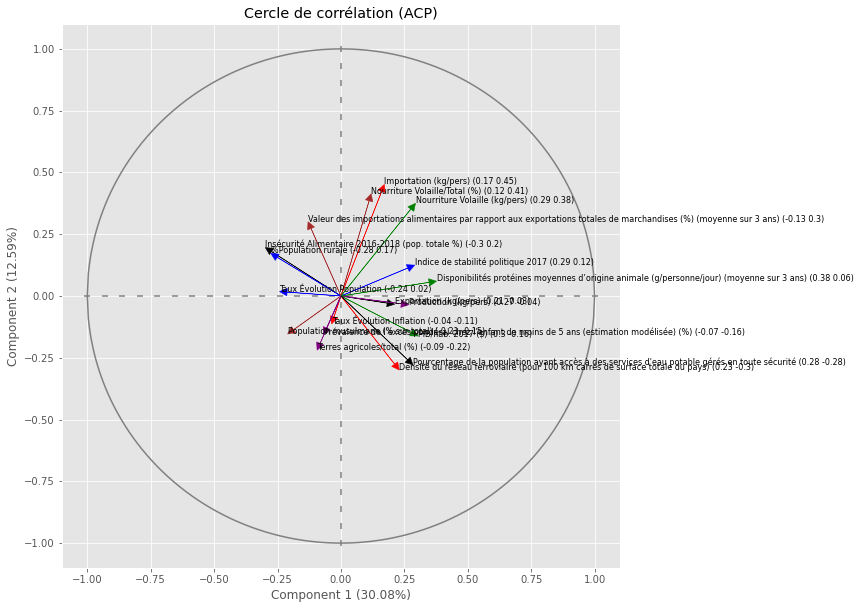

In [42]:
# https://towardsdatascience.com/principal-components-analysis-plot-for-python-311013a33cd9

# Plot circle
pca_values = pca.components_
 
plt.figure(figsize=(10,10))

x = np.linspace(start=-1,stop=1,num=500)
# Find y1 and y2 for these points
y_positive=lambda x: np.sqrt(1-x**2) 
y_negative=lambda x: -np.sqrt(1-x**2)
plt.plot(x,list(map(y_positive, x)), color='gray')
plt.plot(x,list(map(y_negative, x)),color='gray')
         
# Create broken lines
x = np.linspace(start=-1,stop=1,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='gray')
plt.scatter([0]*len(x), x, marker='|',color='gray')

# Define color list
colors = ['blue', 'red', 'green', 'black', 'purple', 'brown']
if len(pca_values[0]) > 6:
    colors=colors*(int(len(pca_values[0])/6)+1)
    
add_string=""
for i in range(len(pca_values[0])):
    xi=pca_values[comp1][i]
    yi=pca_values[comp2][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.03, 
              color=colors[i], length_includes_head=True)
    add_string=f" ({round(xi,2)} {round(yi,2)})"
    plt.text(pca_values[comp1, i], 
             pca_values[comp2, i], 
             s=df.columns[i] + add_string, 
             size=8)
    
plt.xlabel(f"Component {comp1+1} ({round(pca.explained_variance_ratio_[comp1]*100,2)}%)")
plt.ylabel(f"Component {comp2+1} ({round(pca.explained_variance_ratio_[comp2]*100,2)}%)")
plt.title('Cercle de corrélation (ACP)')
plt.show()

Nous voyons que globalement la première dimension ou variable synthétique explique environ 30% de l’information. La deuxième dimension quant à elle explique environ 13%. Ces deux dimensions combinées nous permettent d’expliquer sensiblement 43% de la variabilité entre les pays.

### Projection des individus sur le plan factoriel

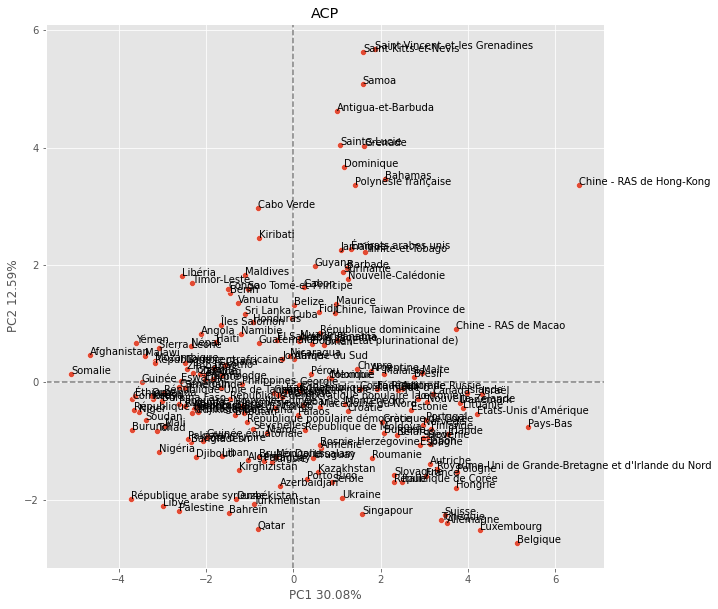

In [43]:
# Afficher PCA
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=X_pca[:, comp1], y=X_pca[:, comp2])
plt.xlabel("PC{:.0f} {:.2f}%".format(comp1+1, (pca.explained_variance_ratio_ * 100)[comp1]))
plt.ylabel("PC{:.0f} {:.2f}%".format(comp2+1, (pca.explained_variance_ratio_ * 100)[comp2]))
plt.title('ACP')

# Afficher labels
for i, (x,y) in enumerate(zip(X_pca[:, comp1], X_pca[:, comp2])):
    plt.text(x, y, df.index[i])

# Axe origine
ax.grid(True, which='both')
ax.axhline(y=0, color='gray', ls='--')
ax.axvline(x=0, color='gray', ls='--')

In [44]:
# DataFrame scaled
df_scaled = pd.DataFrame(data=X_scaled, index=df.index ,columns=df.columns.tolist())

### Contribution des individus

In [45]:
df_acp = pd.DataFrame(X_pca, index=df.index, columns=["F"+str(i+1) for i in range(n_comp)])
df_acp
# df_acp.sort_values(by='F3')

,F1,F2,F3,F4,F5,F6,F7,F8
Zone,,,,,,,,
Afghanistan,-4.663407,0.474097,0.571069,-0.249814,2.936325,0.718236,-1.615872,-0.277087
Afrique du Sud,0.025893,0.394283,-2.581131,-0.535963,0.171275,-0.050275,0.566083,-0.147460
Albanie,0.232040,-0.376004,-1.031699,-0.196019,-0.061435,1.503388,-0.188780,-1.456960
Algérie,-1.034231,-1.319563,-0.679922,1.703064,0.137055,1.450338,-0.580752,-0.533140
Allemagne,3.520562,-2.388136,0.833401,-1.202325,0.731667,-0.344374,-0.904597,0.449482
Angola,-2.114037,0.826069,0.210237,0.740114,-0.343861,-1.291892,1.125681,0.619076
Antigua-et-Barbuda,1.000995,4.625517,0.962995,-0.417159,0.646276,-0.293714,-0.516362,0.068897
Arabie saoudite,0.137136,0.701727,-1.900697,1.920666,1.870545,0.668689,-0.429243,1.196164
Argentine,1.790500,0.187269,-2.423452,0.559467,-0.830095,0.056483,0.739920,-0.710495


### Interprétation de l'ACP

#### Interprétation de l'axe 1
Variables\
++ Disponibilité protéines / PIB \
-- Insécurité Alimentaire\
Individus\
++ Chine - RAS de Hong-Kong / Pays-Bas / Belgique\
-- Somalie / Afghanistan / République arabe syrienne

#### Interprétation de l'axe 2
Variables\
++ Importation (kg/pers) / Nourriture Volaille/Total (%)\
-- Densité féroviaire / Accès eau potable\
Individus\
++ Saint-Kitts-et-Nevis / Saint-Vincent-et-les Grenadines / Samoa\
-- Belgique / Luxembourg / Qatar

#### Interprétation de l'axe 3
Variables\
++ PIB / Indice de stabilité politique\
-- Production / Excès pondéral\
Individus\
++ Palaos / Saint-Kitts-et-Nevis / Chine - RAS de Hong-Kong\
-- Ukraine / Australie / Jamaïque

### Clustering par K-Means

Algorithme des centres mobiles\
La méthode des K-means est un algorithme non supervisé de clustering, c'est à dire de partitionnement des données en des groupes homogènes admettant des caractéristiques communes.

Fonctionnement de l'algorithme:

Etape 1:
Choisir le nombre K de groupes.

Etape 2:
L'algorithme va sélectionner aléatoirement K points du dataset, les centroïdes.

Etape 3:
Pour chaque point du dataset, l'algortihme va calculer la distance entre le point et chaque centroïde. Le point sera assigné au centroïde dont il est le plus proche.

Etape 4:
L'algorithme va calculer le point moyen de chaque groupe afin de définir le nouveau centroïde de chaque groupe et recommence à classer les différents points avec le centroïde qui est le plus proche.
L'algorithme prend fin lorsque les centroïdes ne changent plus.

### Choix du nombre de clusters pour K-Means

#### 1 - Méthode du coude (Elbow Method)

La méthode du coude s’appuie sur la notion d’inertie. On définit cette dernière comme ceci : la somme des distances euclidiennes entre chaque point et son centroïde associé. Evidemment plus on fixe un nombre initial de clusters élevés et plus on réduit l’inertie : les points ont plus de chance d’être à côté d’un centroïde.  Cette méthode représente la distance moyenne de chaque point d'un cluster à son centre de gravité, il faut choisir la valeur de k, où la distance moyenne tombe soudainement.

C:\Users\Valentina\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


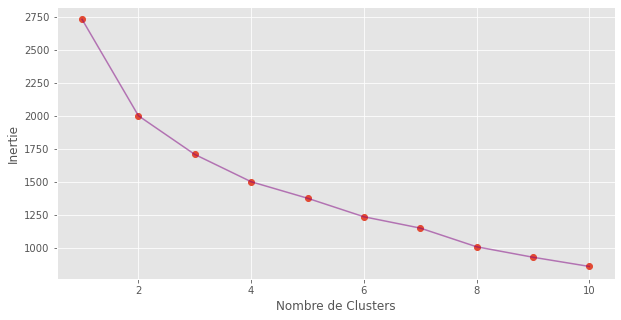

In [46]:
# Calculer l'inertie
inertia_all = []
for n in range(.1 , 11):
    km = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300, tol=0.0001, random_state= 19))
    km.fit(X_pca)
    inertia_all.append(km.inertia_)

# Tracer la courbe des clusters vs l'inertie
plt.figure(figsize = (10 ,5))
plt.plot(np.arange(1 , 11) , inertia_all, 'o')
plt.plot(np.arange(1 , 11) , inertia_all, '-' , alpha = 0.5, color = 'purple')
plt.xlabel('Nombre de Clusters') , plt.ylabel('Inertie')
plt.show()

#### 2 - Silhouette score

La valeur de la silhouette est une mesure de la similitude d'un objet avec son propre cluster ( cohésion ) par rapport à d'autres clusters ( séparation ). La valeur de la silhouette est comprise entre [1, -1], où une valeur élevée indique que l'objet est bien adapté à son propre cluster et mal adapté aux clusters voisins. Si la plupart des objets ont une valeur élevée, la configuration de clustering est appropriée. Si de nombreux points ont une valeur faible ou négative, la configuration de clustering peut avoir trop ou trop peu de clusters.

For n_clusters = 2 The average silhouette_score is : 0.2571901585173749
For n_clusters = 3 The average silhouette_score is : 0.2344656432100513
For n_clusters = 4 The average silhouette_score is : 0.24470305339169313
For n_clusters = 5 The average silhouette_score is : 0.24938759911120367


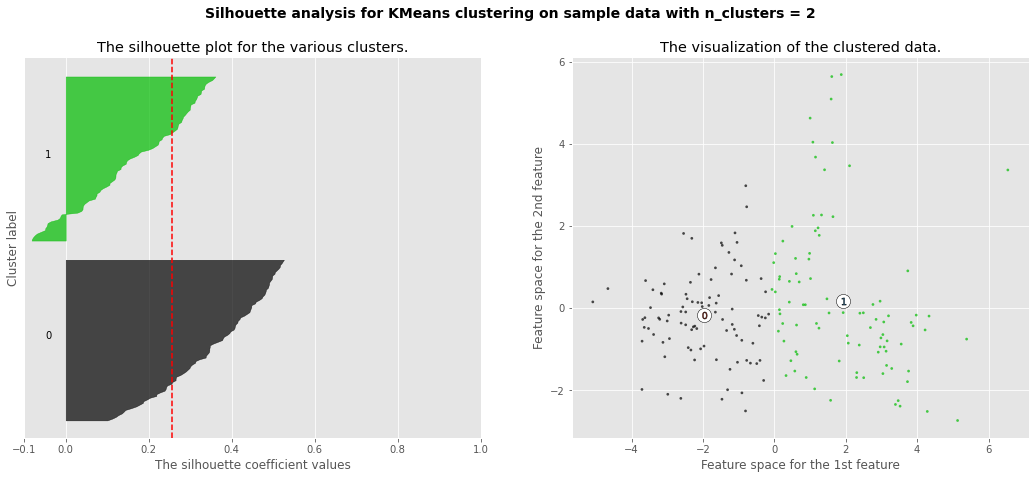

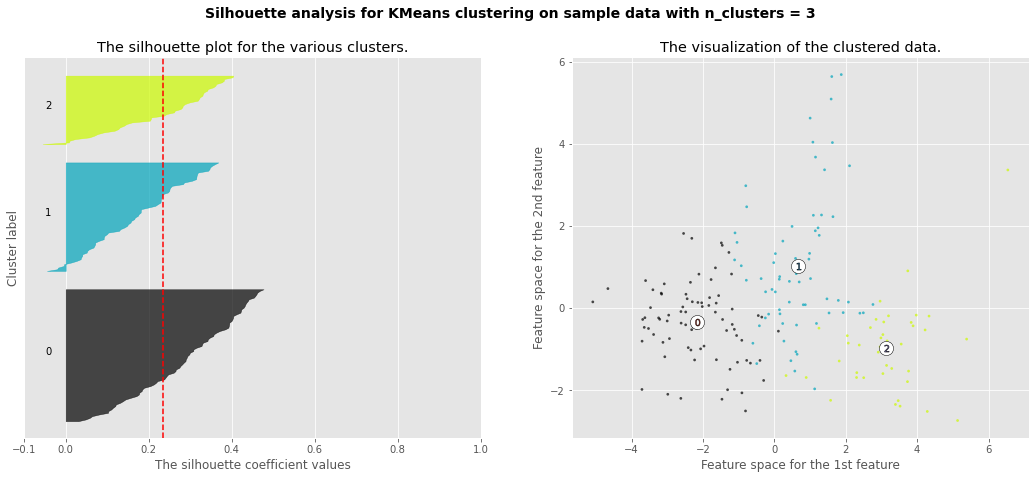

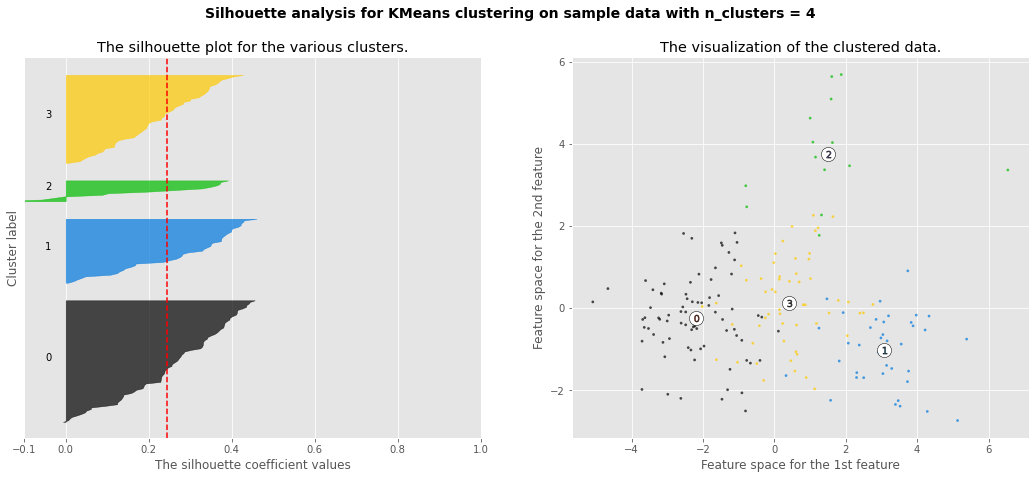

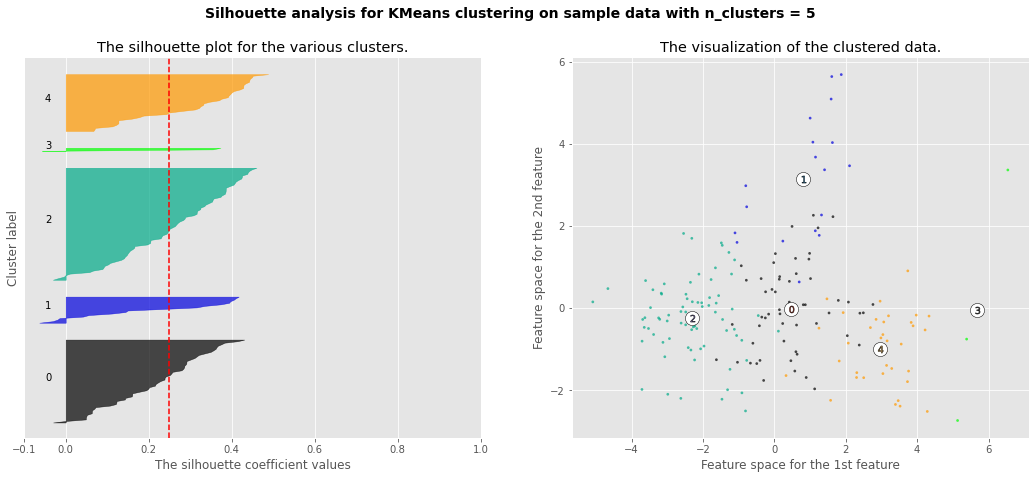

In [47]:
#https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

kX = X_pca

range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(kX) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(kX)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(kX, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(kX, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(kX[:, 0], kX[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Afficher le clustering par K-Means

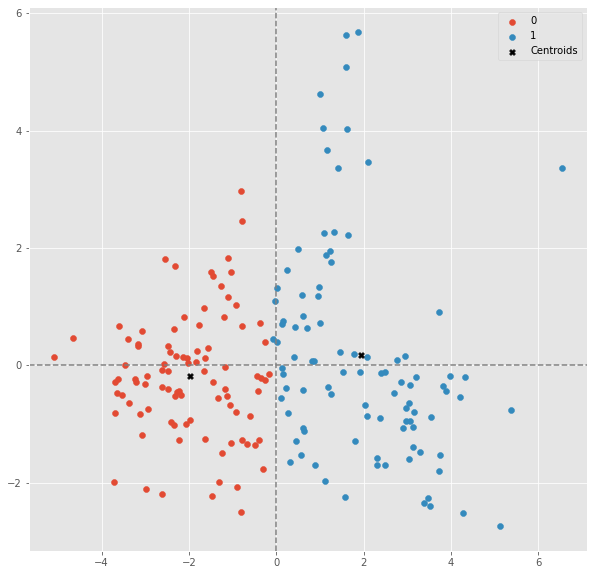

In [48]:
# Nombre de clusters souhaités
n_clust = 2

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_pca)

# Récupération des clusters attribués à chaque individu
label = km.fit_predict(X_pca)
u_labels = np.unique(label)

df_clust = df.copy() # création d'une copie du df avec colonne de clusters supplémentaire
df_clust['Clusters'] = label

# Afficher le nuage de points
fig, ax = plt.subplots(figsize=(10,10))
for i in u_labels:
    plt.scatter(X_pca[label == i , comp1], X_pca[label == i, comp2], label=i, cmap='hls' )

# Afficher les centroïdes
plt.scatter(km.cluster_centers_[:, comp1], km.cluster_centers_[:, comp2], c='black', marker="X", label='Centroids')

# Axe origine
ax.grid(True, which='both')
ax.axhline(y=0, color='gray', ls='--')
ax.axvline(x=0, color='gray', ls='--')

plt.legend()
plt.show()

In [49]:
# df_clust.sort_values(by='Clusters')

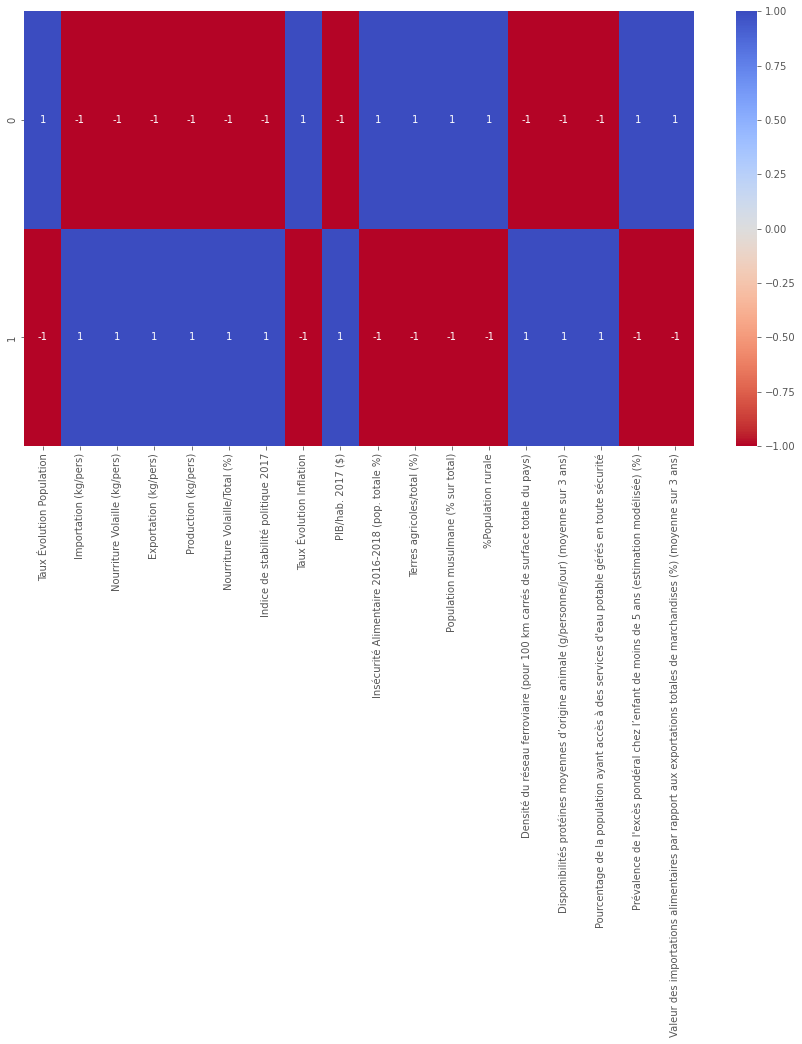

In [50]:
# Grouper par cluster (moyenne) et centrer/réduire les données
clust_scaled = scaler.fit_transform(df_clust.groupby('Clusters').mean().values)
clust_scaled = pd.DataFrame(data=clust_scaled, columns=df.columns.to_list())

# Afficher heatmap
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.heatmap(clust_scaled, annot=True, cmap="coolwarm_r")
plt.show()

### Résultats du K-Means
Le cluster 1 semble être intéressant car ils regroupent des pays qui consomment beaucoup de volaille et qui en importent beaucoup.
Ce sont plutôt des pays développés (PIB, stabilité politique) qui possèdent un bon réseau ferroviaire ainsi qu'un accès à l'eau potable géré en toute sécurité.

In [59]:
# Filtre sur cluster
df_clust[df_clust['Clusters'] == 1]

,Taux Évolution Population,Importation (kg/pers),Nourriture Volaille (kg/pers),Exportation (kg/pers),Production (kg/pers),Nourriture Volaille/Total (%),Indice de stabilité politique 2017,Taux Évolution Inflation,PIB/hab. 2017 ($),Insécurité Alimentaire 2016-2018 (pop. totale %),Terres agricoles/total (%),Population musulmane (% sur total),%Population rurale,Densité du réseau ferroviaire (pour 100 km carrés de surface totale du pays),Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Pourcentage de la population ayant accès à des services d'eau potable gérés en toute sécurité,Prévalence de l'excès pondéral chez l’enfant de moins de 5 ans (estimation modélisée) (%),Valeur des importations alimentaires par rapport aux exportations totales de marchandises (%) (moyenne sur 3 ans),Clusters
Zone,,,,,,,,,,,,,,,,,,,
Afrique du Sud,0.014013,9.02,35.70,1.11,29.24,59.48,-0.28,0.230740,12701.3,43.900000,79.417850,1.818950,33.974890,1.7,36.0,0.0,12.9,6.0,1
Albanie,-0.004211,13.18,16.30,0.00,4.51,34.57,0.38,-0.299215,12771.0,38.600000,42.737226,58.799988,41.265092,0.0,62.7,70.6,16.4,21.0,1
Allemagne,0.000972,10.19,19.47,7.82,18.32,22.18,0.59,-0.008286,52952.9,3.600000,51.798952,5.421687,22.589474,9.4,63.0,99.0,3.9,5.0,1
Antigua-et-Barbuda,0.013221,73.36,52.40,0.00,0.00,71.43,0.75,-1.035424,19840.3,28.332543,20.454545,1.042949,80.483306,0.0,50.0,0.0,0.0,98.0,1
Arabie saoudite,0.028641,21.81,43.35,0.30,18.61,80.11,-0.58,-0.437991,47306.2,28.332543,80.763738,97.998247,16.297274,0.1,34.6,0.0,7.3,8.0,1
Argentine,0.010328,0.18,42.24,4.71,49.18,38.62,0.17,-0.362995,23597.1,32.300000,40.647278,0.894971,8.313705,0.6,67.3,0.0,12.7,5.0,1
Arménie,-0.003730,11.89,15.96,0.00,3.74,35.08,-0.62,-0.735385,12115.1,14.800000,71.794872,0.099993,36.717309,2.3,44.7,85.4,11.6,26.0,1
Australie,0.015035,0.65,47.63,1.71,51.62,39.18,0.89,0.693929,48482.6,12.700000,51.195525,2.600000,14.019489,0.0,71.6,0.0,17.3,5.0,1
Autriche,0.005094,12.47,18.14,8.84,16.78,20.81,1.05,0.124515,54170.0,4.400000,32.174018,8.000000,41.505080,5.9,64.7,98.9,0.0,7.0,1


### Classification Ascendante Hiérarchique (Dendrogramme)

On cherche à ce que les individus regroupés au sein d’une même classe (homogénéité intra-classe) soient le plus semblables possibles tandis que les classes soient le plus dissemblables (hétérogénéité inter-classe)

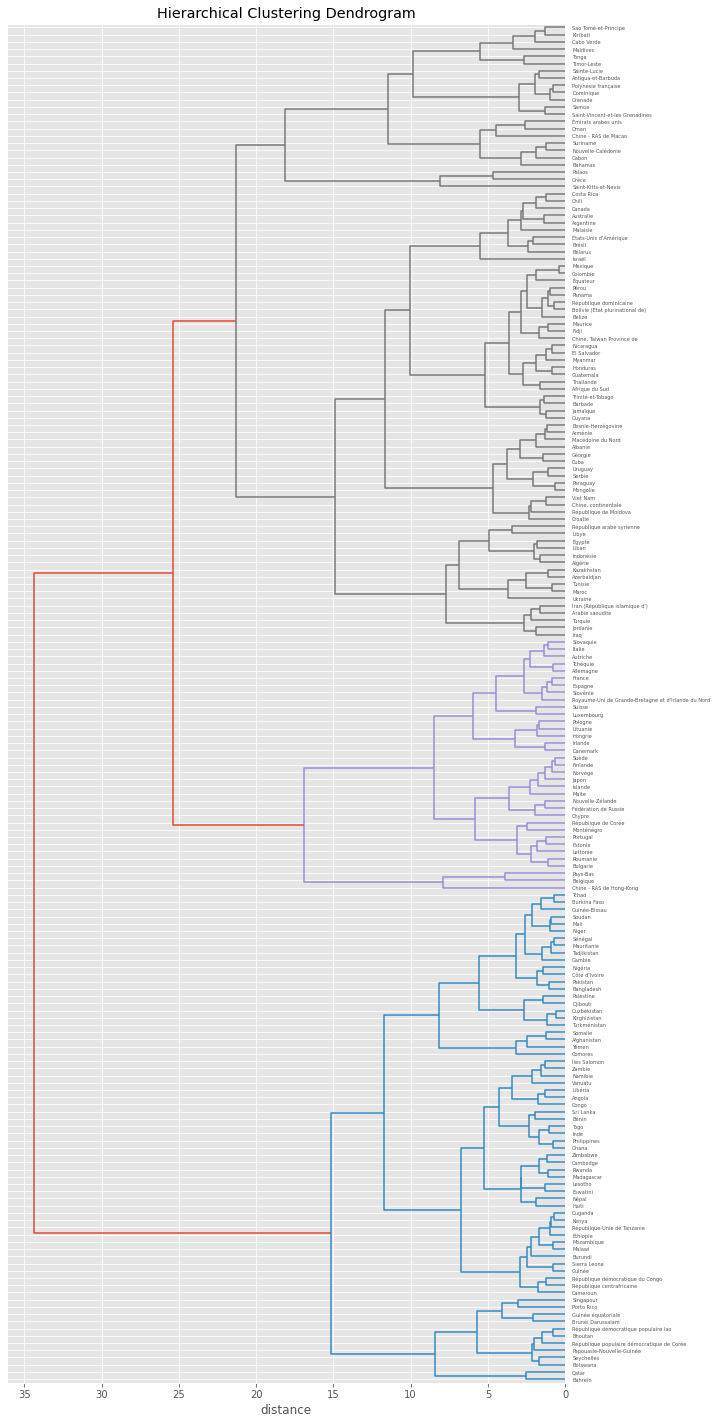

In [52]:
# Fonction OPC pour dendogramme
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# CAH
# Utilisation des données centrées et réduites de l'ACP

names = df.index

# Clustering hiérarchique
Z = linkage(X_pca, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

In [53]:
# Récupération des clusters attribués à chaque individu
df_dend = df.copy() # création d'une copie du df avec colonne de clusters supplémentaire
label_d = fcluster(Z, 3, criterion='maxclust')
df_dend['Clusters'] = label_d
u_label_d = np.unique(label_d)
# df_dend.sort_values(by='Clusters')

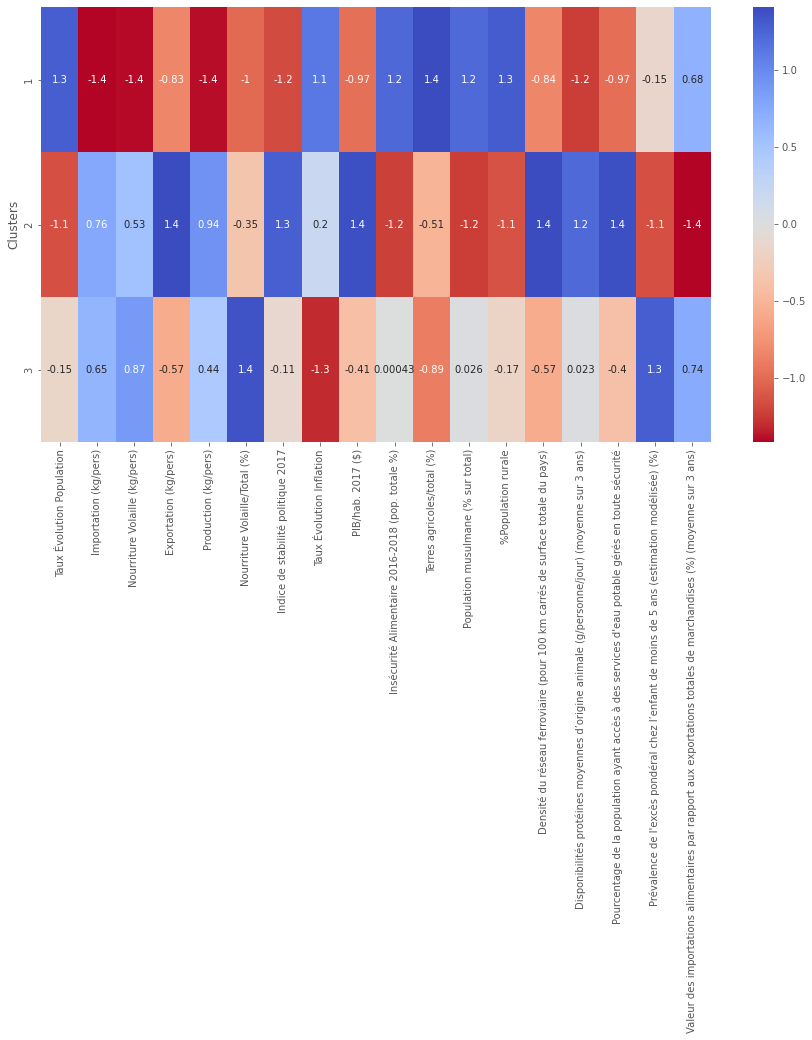

In [54]:
# Grouper par cluster (moyenne) et centrer/réduire les données
dend_scaled = scaler.fit_transform(df_dend.groupby('Clusters').mean())
dend_scaled = pd.DataFrame(data=dend_scaled, 
                           index=df_dend.groupby('Clusters').mean().index, 
                           columns=df.columns.to_list())

# Afficher heatmap
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.heatmap(dend_scaled, annot=True, cmap="coolwarm_r")
plt.show()

### Résultats de la CAH
Le cluster 2 pourrait nous intéresser car  ils regroupent des pays qui importent, produisent, exportent  beaucoup de volaille. Ils en consomment modérément\
Ce sont plutôt des pays développés (PIB, stabilité politique élevé) qui possèdent un bon réseau ferroviaire et un accès sécurisé à l’eau potable.\
Ils ont un taux d’évolution de population faible, tout comme l’insécurité alimentaire, population musulmane, population rurale, d’enfants en excès pondéral et importation alimentaire moindre par rapport aux exportations\
L’évolution du taux d’inflation est faible et la part des terres agricoles sur la superficie totale est moyenne\
Il regroupe moins d’individus que le cluster 1 du K-Means\
Les individus du cluster 2 sont également présent dans le cluster 1 du K-Means

In [55]:
# Filtre sur cluster
df_dend[df_dend['Clusters'] == 2]

,Taux Évolution Population,Importation (kg/pers),Nourriture Volaille (kg/pers),Exportation (kg/pers),Production (kg/pers),Nourriture Volaille/Total (%),Indice de stabilité politique 2017,Taux Évolution Inflation,PIB/hab. 2017 ($),Insécurité Alimentaire 2016-2018 (pop. totale %),Terres agricoles/total (%),Population musulmane (% sur total),%Population rurale,Densité du réseau ferroviaire (pour 100 km carrés de surface totale du pays),Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Pourcentage de la population ayant accès à des services d'eau potable gérés en toute sécurité,Prévalence de l'excès pondéral chez l’enfant de moins de 5 ans (estimation modélisée) (%),Valeur des importations alimentaires par rapport aux exportations totales de marchandises (%) (moyenne sur 3 ans),Clusters
Zone,,,,,,,,,,,,,,,,,,,
Allemagne,0.000972,10.19,19.47,7.82,18.32,22.18,0.59,-0.008286,52952.9,3.600000,51.798952,5.421687,22.589474,9.4,63.0,99.0,3.9,5.0,2
Autriche,0.005094,12.47,18.14,8.84,16.78,20.81,1.05,0.124515,54170.0,4.400000,32.174018,8.000000,41.505080,5.9,64.7,98.9,0.0,7.0,2
Belgique,0.006153,29.60,12.61,57.44,40.54,19.20,0.43,-0.188355,50442.3,3.700000,43.824306,7.599992,2.041175,11.8,58.3,99.0,4.9,7.0,2
Bulgarie,-0.006940,15.21,22.11,6.34,15.07,37.84,0.33,-2.801100,21387.3,12.000000,46.333825,12.199993,25.267556,3.6,40.7,97.4,6.0,9.0,2
Chine - RAS de Hong-Kong,0.006020,124.14,53.52,90.74,3.28,39.03,0.83,-0.601843,59849.2,28.332543,4.761905,4.099988,0.000000,0.0,95.7,99.0,0.0,4.0,2
Chypre,0.013231,11.87,25.43,0.85,21.19,34.88,0.54,-0.626519,38050.9,28.332543,13.203463,25.000000,33.160913,0.0,46.0,99.0,0.0,26.0,2
Danemark,0.004165,23.20,28.96,24.25,30.18,40.99,0.87,0.827457,55356.7,5.400000,65.800000,5.399998,12.245943,0.0,76.7,96.7,0.0,8.0,2
Espagne,0.007519,4.39,30.40,4.54,32.48,30.33,0.28,-0.506008,39528.9,7.500000,52.639375,2.528971,19.795128,3.1,66.0,99.0,0.0,8.0,2
Estonie,-0.003141,15.92,21.22,8.34,15.16,33.33,0.65,-1.475834,33856.2,8.200000,23.050380,0.121194,31.051243,2.3,64.0,95.8,5.5,9.0,2


### Visualiser un autre plan factoriel

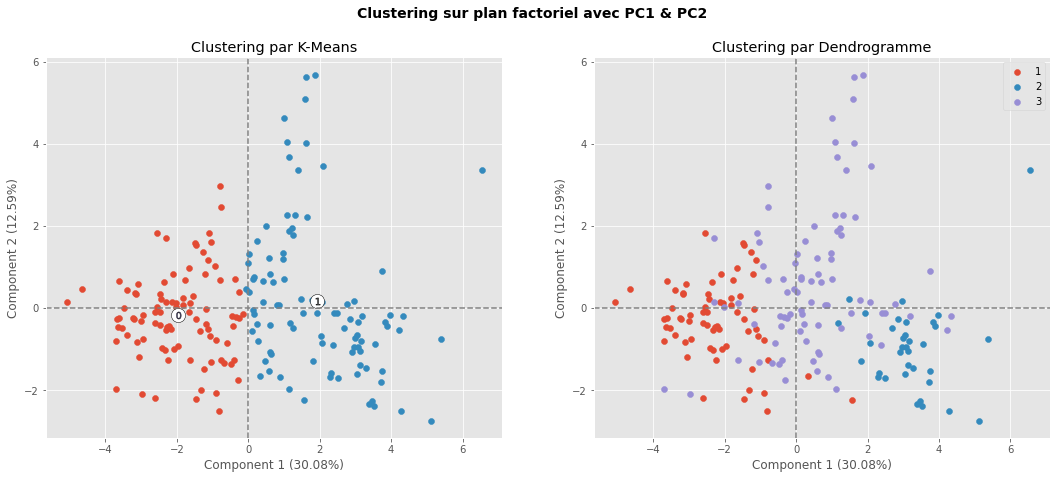

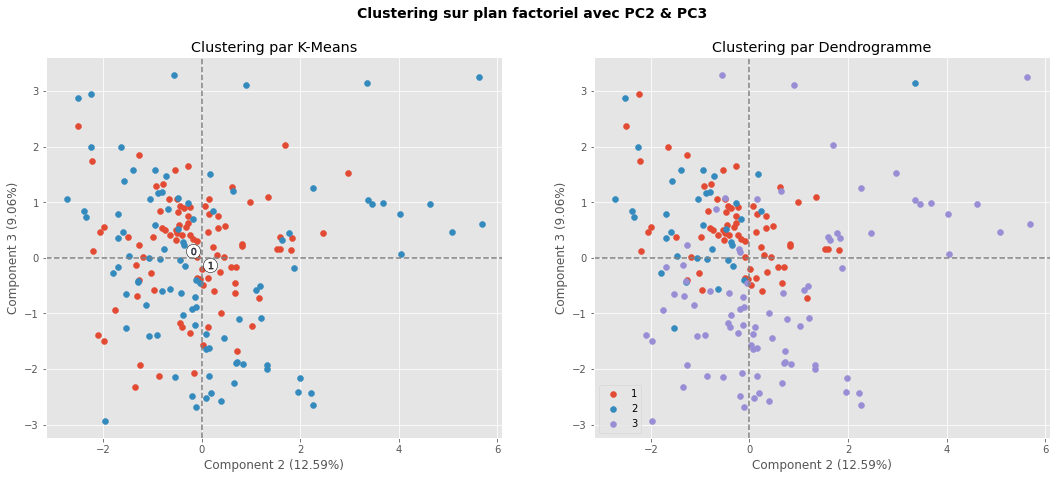

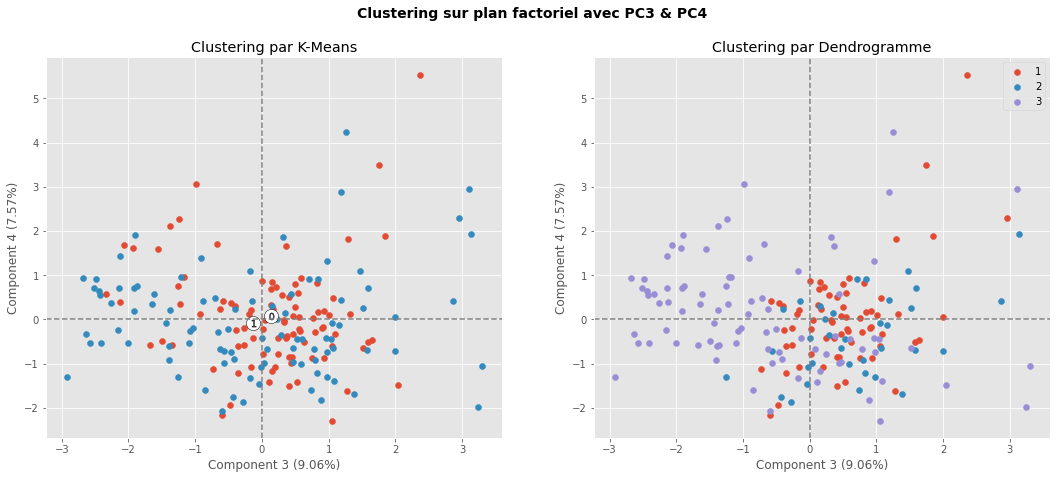

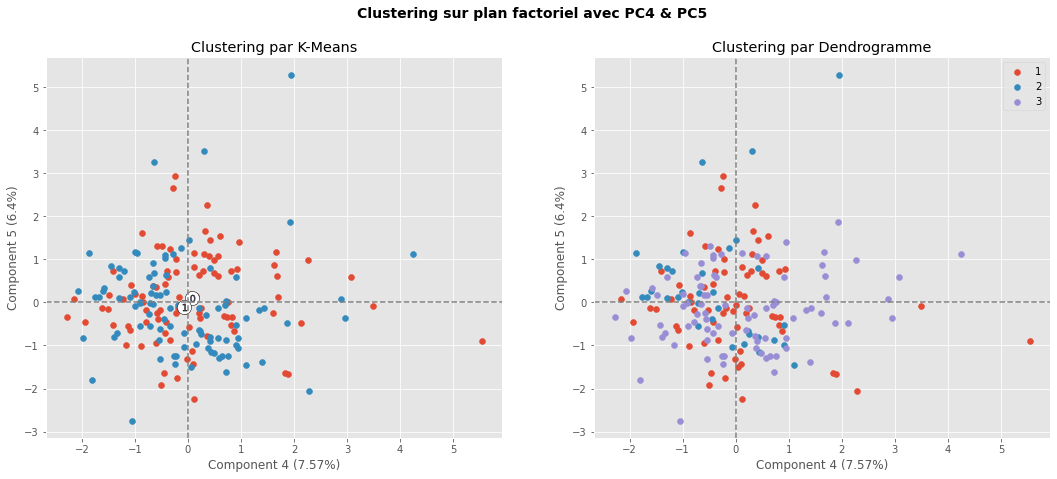

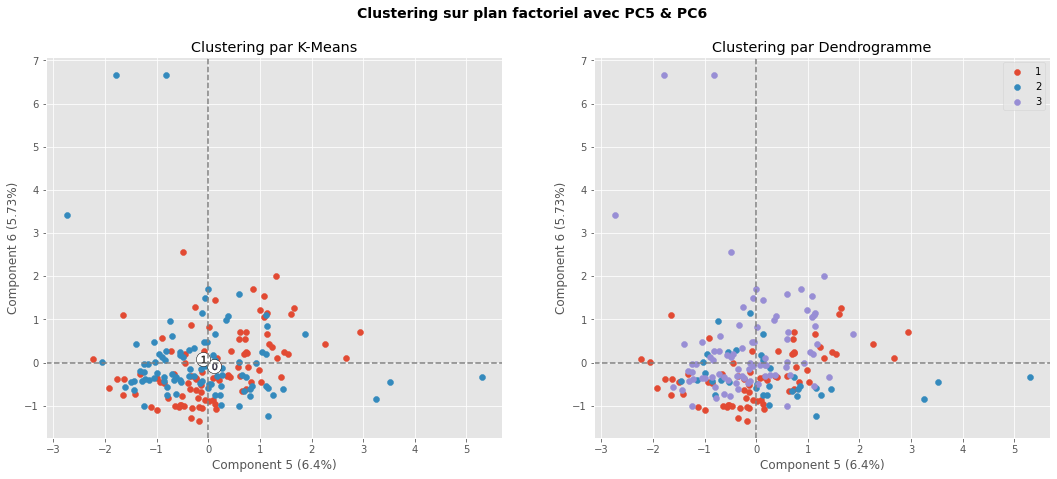

In [56]:
kX = X_pca

range_n_comp = [0, 1, 2, 3, 4]
for n_comp in range_n_comp:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the kmeans clustering
    for i in u_labels:
        ax1.scatter(kX[label == i , [n_comp]], kX[label == i, [n_comp+1]], label = i, cmap='jet')
    
    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax1.scatter(centers[:, n_comp], centers[:, n_comp+1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax1.scatter(c[n_comp], c[n_comp+1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        
    # Axe origine
    ax1.grid(True, which='both')
    ax1.axhline(y=0, color='gray', ls='--')
    ax1.axvline(x=0, color='gray', ls='--')

    ax1.set_title("Clustering par K-Means")
    ax1.set_xlabel(f"Component {n_comp+1} ({round(pca.explained_variance_ratio_[n_comp]*100,2)}%)")
    ax1.set_ylabel(f"Component {n_comp+2} ({round(pca.explained_variance_ratio_[n_comp+1]*100,2)}%)")

    # 2nd Plot showing the dendrogram clustering
    for i in u_label_d:
        ax2.scatter(X_pca[label_d == i , [n_comp]], X_pca[label_d == i, [n_comp+1]], label = i, cmap='jet')
    
    # Axe origine
    ax2.grid(True, which='both')
    ax2.axhline(y=0, color='gray', ls='--')
    ax2.axvline(x=0, color='gray', ls='--')

    ax2.set_title("Clustering par Dendrogramme")
    ax2.set_xlabel(f"Component {n_comp+1} ({round(pca.explained_variance_ratio_[n_comp]*100,2)}%)")
    ax2.set_ylabel(f"Component {n_comp+2} ({round(pca.explained_variance_ratio_[n_comp+1]*100,2)}%)")
    ax2.legend()

    plt.suptitle((f"Clustering sur plan factoriel avec PC{n_comp+1} & PC{n_comp+2}"), fontsize=14, fontweight='bold')

plt.show()

In [57]:
# # Clustering avec les 4 premières composantes principales
# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))

# for i in u_labels:
#     ax[0,0].scatter(X_pca[label == i , [0]], X_pca[label == i, [1]], label = i, cmap='jet')
# ax[0,0].scatter(km.cluster_centers_[:, [0]], km.cluster_centers_[:, [1]], c = 'black', marker="X", label = 'Centroids')
# ax[0,0].set_xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
# ax[0,0].set_ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
# # Axe origine
# ax[0,0].grid(True, which='both')
# ax[0,0].axhline(y=0, color='gray', ls='--')
# ax[0,0].axvline(x=0, color='gray', ls='--')

# for i in u_labels:
#     ax[0,1].scatter(X_pca[label == i , [2]], X_pca[label == i, [3]], label = i, cmap='jet')
# ax[0,1].scatter(km.cluster_centers_[:, [2]], km.cluster_centers_[:, [3]], c = 'black', marker="X", label = 'Centroids')
# ax[0,1].set_xlabel(f"Component 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)")
# ax[0,1].set_ylabel(f"Component 4 ({round(pca.explained_variance_ratio_[3]*100,2)}%)")
# # Axe origine
# ax[0,1].grid(True, which='both')
# ax[0,1].axhline(y=0, color='gray', ls='--')
# ax[0,1].axvline(x=0, color='gray', ls='--')

# for i in u_labels:
#     ax[1,0].scatter(X_pca[label == i , [0]], X_pca[label == i, [2]], label = i, cmap='jet')
# ax[1,0].scatter(km.cluster_centers_[:, [0]], km.cluster_centers_[:, [2]], c = 'black', marker="X", label = 'Centroids')
# ax[1,0].set_xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
# ax[1,0].set_ylabel(f"Component 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)")
# # Axe origine
# ax[1,0].grid(True, which='both')
# ax[1,0].axhline(y=0, color='gray', ls='--')
# ax[1,0].axvline(x=0, color='gray', ls='--')

# for i in u_labels:
#     ax[1,1].scatter(X_pca[label == i , [1]], X_pca[label == i, [3]], label = i, cmap='jet')
# ax[1,1].scatter(km.cluster_centers_[:, [1]], km.cluster_centers_[:, [3]], c = 'black', marker="X", label = 'Centroids')
# ax[1,1].set_xlabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
# ax[1,1].set_ylabel(f"Component 4 ({round(pca.explained_variance_ratio_[3]*100,2)}%)")
# # Axe origine
# ax[1,1].grid(True, which='both')
# ax[1,1].axhline(y=0, color='gray', ls='--')
# ax[1,1].axvline(x=0, color='gray', ls='--')

# for i in u_labels:
#     ax[2,0].scatter(X_pca[label == i , [1]], X_pca[label == i, [2]], label = i, cmap='jet')
# ax[2,0].scatter(km.cluster_centers_[:, [1]], km.cluster_centers_[:, [2]], c = 'black', marker="X", label = 'Centroids')
# ax[2,0].set_xlabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
# ax[2,0].set_ylabel(f"Component 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)")
# # Axe origine
# ax[2,0].grid(True, which='both')
# ax[2,0].axhline(y=0, color='gray', ls='--')
# ax[2,0].axvline(x=0, color='gray', ls='--')

# for i in u_labels:
#     ax[2,1].scatter(X_pca[label == i , [0]], X_pca[label == i, [3]], label = i, cmap='jet')
# ax[2,1].scatter(km.cluster_centers_[:, [0]], km.cluster_centers_[:, [3]], c = 'black', marker="X", label = 'Centroids')
# ax[2,1].set_xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
# ax[2,1].set_ylabel(f"Component 4 ({round(pca.explained_variance_ratio_[3]*100,2)}%)")
# # Axe origine
# ax[2,1].grid(True, which='both')
# ax[2,1].axhline(y=0, color='gray', ls='--')
# ax[2,1].axvline(x=0, color='gray', ls='--')

# plt.show()


In [58]:
# # Afficher PCA sur un autre plan factoriel
# comp1 = 2
# comp2 = 3

# fig, ax = plt.subplots(figsize=(10,10))
# sns.scatterplot(x=X_pca[:, comp1], y=X_pca[:, comp2])
# plt.xlabel("PC{:.0f} {:.2f}%".format(comp1+1, (pca.explained_variance_ratio_ * 100)[comp1]))
# plt.ylabel("PC{:.0f} {:.2f}%".format(comp2+1, (pca.explained_variance_ratio_ * 100)[comp2]))
# plt.title('ACP')

# # Afficher labels
# for i, (x,y) in enumerate(zip(X_pca[:, comp1], X_pca[:, comp2])):
#     plt.text(x, y, df.index[i])

# # Axe origine
# ax.grid(True, which='both')
# ax.axhline(y=0, color='gray', ls='--')
# ax.axvline(x=0, color='gray', ls='--')

### Recommandations

Il semblerait que le cluster 2 de la CAH puisse être une première piste de réflexion pour l’exportation des poulets. Il regroupe principalement des pays d’Europe qui consomment  de la volaille et qui en importent beaucoup. Même s’ils en produisent également cela ne les empêchent pas d’importer en quantité (exemple Belgique ou Hong Kong). Grâce à la libre circulation des marchandises au sein de l’Union Européenne, cela peut faciliter une première exportation à l’internationale. De plus ce cluster présente une densité de réseau ferroviaire élevé ce qui peut réduire les coûts logistiques.
Si volonté de s’exporter hors d’Europe il y a également quelques pays asiatiques présents dans le cluster: Japon, Hong Kong, Corée